<a href="https://colab.research.google.com/github/AbbasRahimi/netgan/blob/Ecore_model_generator/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b Ecore_model_generator https://github.com/AbbasRahimi/netgan.git

fatal: destination path 'netgan' already exists and is not an empty directory.


In [2]:
%cd netgan
#!pip install python-igraph


C:\Users\AbbasRahimi\PycharmProjects\netgan\netgan


In [ ]:

!pip install -r requirements.txt


In [1]:
#import tensorflow as tf
from netgan.netgan import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from netgan import utils
import scipy.sparse as sp
from netgan import graph_utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
%cd ..

#### Load the data

In [2]:
_A_obs,out1, out2, out3, out4, out5, out6, out7 = utils.load_csr_from_model("car_wash.ecore","CarWash02.xmi")
# _A_obs,out1, out2, out3, out4, out5, out6 = utils.load_csr_from_model("basicfamily.ecore","Family100.xmi")
lcc = utils.largest_connected_components(_A_obs)
print("lcc: ",len(lcc))
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Start loading csr from model. (utils.py-line 151)
Matrix for NetGAN:  262 
 [[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
Selecting 1 largest connected components
lcc:  41


(53, 53)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


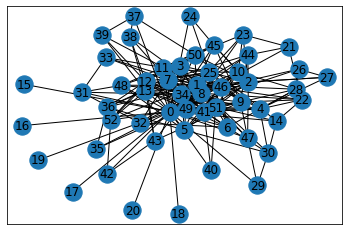

In [3]:
graph_utils.plot_graph_from_sparse_matrix(_A_obs)
# print('A:', type(_A_obs), '\n', _A_obs)
# print('X:', type(_X_obs), '\n', _X_obs)
# print('z:', type(_z_obs), '\n', _z_obs)

In [3]:
val_share = 0.1
test_share = 0.05
#seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, undirected=True, connected=True, asserts=True)

test_ones:  20 neg_mul:  1
n_test: 20 test_zeros.shape[0]: 20


In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [6]:
print(train_graph)

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 20)	1.0
  (0, 25)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 34)	1.0
  (0, 36)	1.0
  (0, 38)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  (1, 0)	1.0
  (1, 17)	1.0
  :	:
  (36, 9)	1.0
  (36, 20)	1.0
  (37, 1)	1.0
  (37, 8)	1.0
  (37, 9)	1.0
  (37, 23)	1.0
  (38, 0)	1.0
  (38, 1)	1.0
  (38, 3)	1.0
  (38, 5)	1.0
  (38, 8)	1.0
  (38, 11)	1.0
  (38, 25)	1.0
  (39, 0)	1.0
  (39, 1)	1.0
  (39, 5)	1.0
  (39, 7)	1.0
  (39, 12)	1.0
  (39, 29)	1.0
  (40, 0)	1.0
  (40, 2)	1.0
  (40, 7)	1.0
  (40, 12)	1.0
  (40, 13)	1.0
  (40, 31)	1.0


#### Parameters

In [7]:
rw_len = 6
batch_size = 32

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### An example random walk

In [9]:
walker.walk().__next__()

array([[15, 34, 15, 17,  2, 34],
       [31, 40, 31,  0,  8,  0],
       [24,  6, 22,  4, 22,  6],
       [11, 27, 11, 38,  3, 19],
       [ 5,  0,  5,  0, 14,  0],
       [14,  0,  1, 26,  8,  0],
       [ 5,  0,  3, 36,  9, 22],
       [25, 28, 25, 28, 10,  0],
       [20,  0, 40,  0,  6,  0],
       [ 3, 38,  0,  2, 17, 10],
       [26, 25, 27, 11, 38,  0],
       [20, 22,  4, 16,  9, 37],
       [36,  3,  0, 38,  0, 13],
       [40,  0,  5, 38, 25, 27],
       [29, 39,  0, 39,  0, 38],
       [34, 15, 34,  7, 30,  5],
       [ 1, 28, 10, 35,  3, 36],
       [33, 13, 40, 31, 32, 13],
       [ 2, 35,  3, 38,  1, 32],
       [21, 20, 22,  9, 34,  1],
       [33, 12, 33, 12, 39, 12],
       [36,  9, 36, 20,  0, 20],
       [23, 37, 23, 24,  4, 36],
       [34,  0, 34,  9, 37,  8],
       [14,  0, 31, 33, 12, 39],
       [29, 30,  7,  0,  3, 38],
       [28, 25, 27, 11, 27, 11],
       [23, 24, 23, 37, 23, 24],
       [35,  9, 22, 20,  0, 10],
       [ 8, 17, 10, 28, 10, 35],
       [ 4

#### Create our NetGAN model

In [10]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=32,batch_size=32,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[10], discriminator_layers=[8], temp_start=5, learning_rate=0.03)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
this is output in generator_recurrent :  Tensor("Generator/add_4:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_9:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_14:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_19:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_24:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator/add_29:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_4:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_9:0", shape=(32, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_1/add_14:0", sh

c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

#### Define the stopping criterion

In [11]:
stopping_criterion = "val"

assert stopping_criterion in ["val", "eo"], "Please set the desired stopping criterion."

if stopping_criterion == "val": # use val criterion for early stopping
    stopping = None
elif stopping_criterion == "eo":  #use eo criterion for early stopping
    stopping = 0.5 # set the target edge overlap here

#### Train the model

In [12]:
eval_every = 100
plot_every = 100

**** Using VAL criterion for early stopping ****
**** Saving snapshots into ../snapshots/model_best_44.ckpt ****
**** Initializing... ****
**** Done.           ****
this is output in generator_recurrent :  Tensor("Generator_2/add_4:0", shape=(30000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_9:0", shape=(30000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_14:0", shape=(30000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_19:0", shape=(30000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_24:0", shape=(30000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_2/add_29:0", shape=(30000, 41), dtype=float32)
**** Starting training. ****
mat is equal:  (41, 41)
**** Iter 100    Val ROC 0.728, AP: 0.792, EO 0.229 ****
mat is equal:  (41, 41)
**** Iter 200    Val ROC 0.615, AP: 0.587, EO 0.397 ****
mat is equ

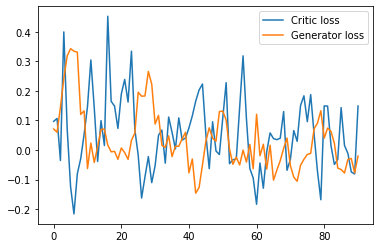

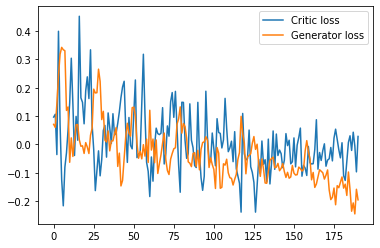

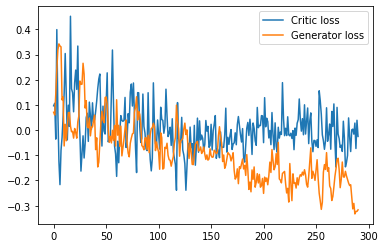

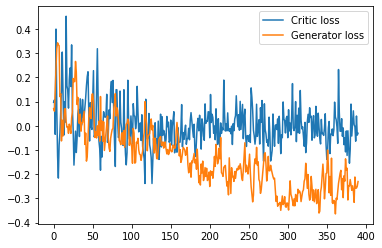

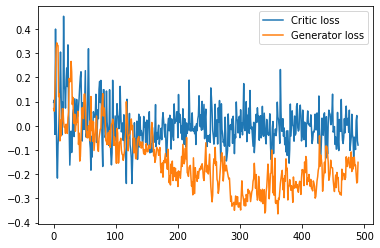

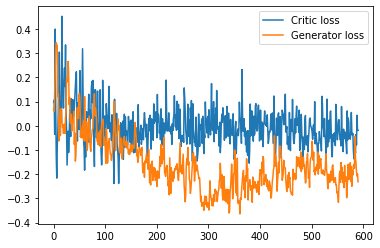

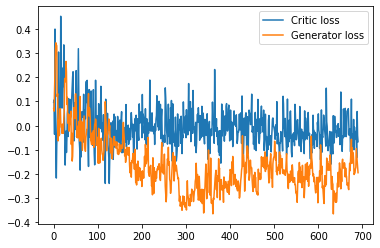

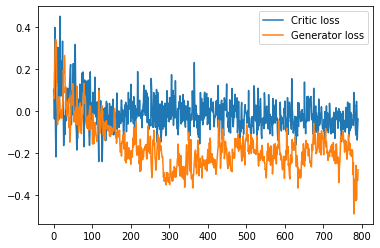

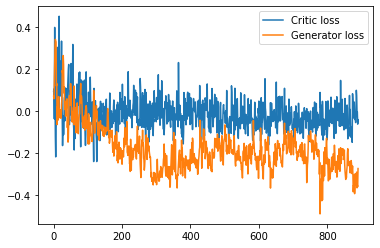

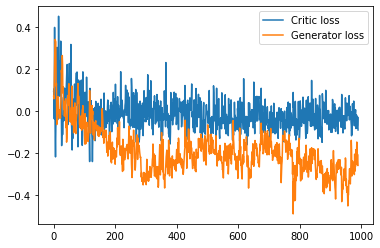

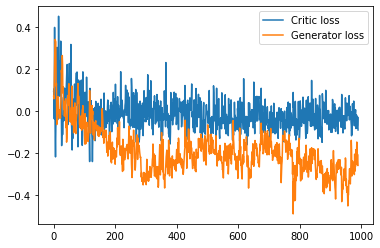

In [13]:
log_dict = netgan.train(A_orig=_A_obs, val_ones=val_ones, val_zeros=val_zeros, stopping=stopping,
                        eval_every=eval_every, plot_every=plot_every, max_patience=5, max_iters=1000)

In [14]:
log_dict.keys()

dict_keys(['disc_losses', 'gen_losses', 'val_performances', 'edge_overlaps', 'generated_graphs'])

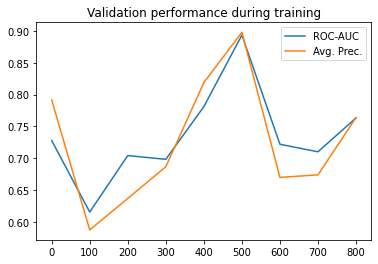

In [15]:
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every, 
         np.array(log_dict['val_performances'])[:,0], label="ROC-AUC")
plt.plot(np.arange(len(log_dict['val_performances'])) * eval_every,
         np.array(log_dict['val_performances'])[:,1], label="Avg. Prec.")

plt.title("Validation performance during training")
plt.legend()
plt.show()

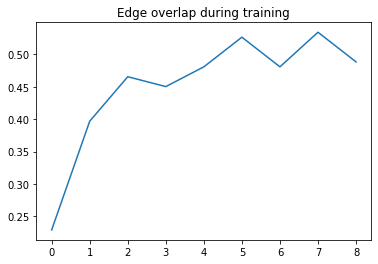

In [16]:
plt.plot(np.array(log_dict['edge_overlaps'])/_A_obs.sum())
plt.title("Edge overlap during training")
plt.show()

#### Generate random walks on the trained model

In [17]:
sample_many = netgan.generate_discrete(3000, reuse=True)

this is output in generator_recurrent :  Tensor("Generator_3/add_4:0", shape=(3000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_9:0", shape=(3000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_14:0", shape=(3000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_19:0", shape=(3000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_24:0", shape=(3000, 41), dtype=float32)
this is output in generator_recurrent :  Tensor("Generator_3/add_29:0", shape=(3000, 41), dtype=float32)


c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\abbasrahimi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  wa

In [18]:
samples = []

In [19]:
for _ in range(1500):
    if (_+1) % 150 == 0:
        print(_)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

149
299
449
599
749
899
1049
1199
1349
1499


#### Assemble score matrix from the random walks

In [20]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()
# graph_utils.plot_graph_from_sparse_matrix(scores_matrix)

mat is equal:  (41, 41)


(41, 41)
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


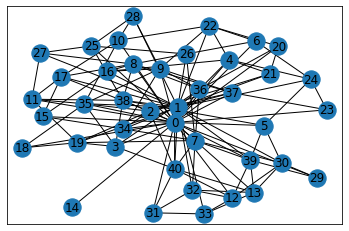

In [21]:
graph_utils.plot_graph_from_sparse_matrix(_A_obs)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 6. 6. 0.]
 [1. 0. 0. ... 6. 0. 0.]
 ...
 [0. 6. 6. ... 0. 0. 0.]
 [0. 6. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(13, 1, 3.658536585365854)
2.048780487804878
1.7142857142857142
3.061224489795918
0.43022030265150973
0.0662020905923345
It's done!!!


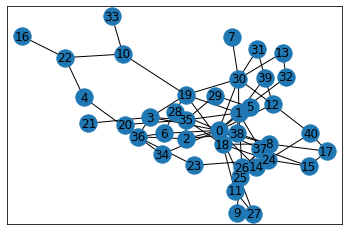

In [44]:
n_edges=150
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 6. 6. 0.]
 [1. 0. 0. ... 6. 0. 0.]
 ...
 [0. 6. 6. ... 0. 0. 0.]
 [0. 6. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(13, 1, 4.878048780487805)
2.292682926829268
1.9183673469387756
4.081632653061225
0.507593618684144
0.08246225319396053
It's done!!!


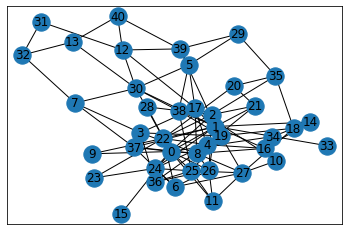

In [26]:
n_edges=200
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 0. ... 3. 3. 3.]
 [1. 0. 0. ... 6. 6. 0.]
 [0. 0. 0. ... 6. 0. 0.]
 ...
 [3. 6. 6. ... 0. 0. 0.]
 [3. 6. 0. ... 0. 0. 1.]
 [3. 0. 0. ... 0. 1. 0.]]
(18, 1, 6.097560975609756)
2.682926829268293
2.2448979591836733
5.1020408163265305
0.6001639586985423
0.12311265969802558
It's done!!!


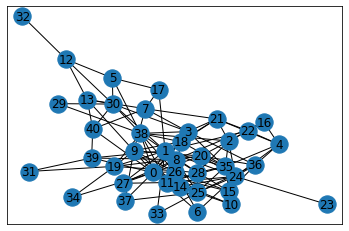

In [28]:
n_edges=250
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 3. 0.]
 [1. 0. 0. ... 6. 0. 0.]
 [1. 0. 0. ... 0. 0. 6.]
 ...
 [3. 6. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 0. 6. ... 0. 0. 0.]]
(23, 3, 7.317073170731708)
2.8536585365853657
2.3877551020408165
6.122448979591836
0.647096766156712
0.13472706155632988
It's done!!!


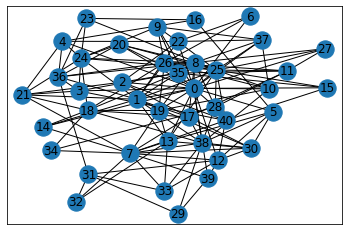

In [30]:
n_edges=300
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 3. 0.]
 [1. 0. 0. ... 6. 6. 0.]
 [1. 0. 0. ... 6. 0. 6.]
 ...
 [3. 6. 6. ... 0. 0. 0.]
 [3. 6. 0. ... 0. 0. 1.]
 [0. 0. 6. ... 0. 1. 0.]]
(27, 2, 8.536585365853659)
3.024390243902439
2.5306122448979593
7.142857142857143
0.6450948138428937
0.15795586527293845
It's done!!!


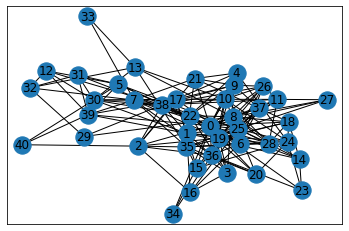

In [32]:
n_edges=350
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 0. 0.]
 [1. 0. 0. ... 6. 6. 0.]
 [1. 0. 0. ... 6. 0. 6.]
 ...
 [3. 6. 6. ... 0. 0. 0.]
 [0. 6. 0. ... 0. 0. 0.]
 [0. 0. 6. ... 0. 0. 0.]]
(24, 4, 9.75609756097561)
2.951219512195122
2.4693877551020407
8.16326530612245
0.6580604132807681
0.1440185830429733
It's done!!!


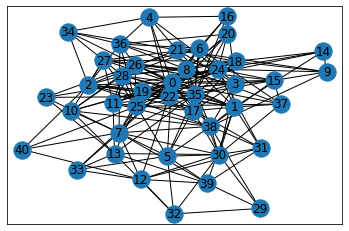

In [34]:
n_edges=400
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 3. 0.]
 [1. 0. 0. ... 6. 6. 0.]
 [1. 0. 0. ... 6. 0. 6.]
 ...
 [3. 6. 6. ... 0. 0. 1.]
 [3. 6. 0. ... 0. 0. 0.]
 [0. 0. 6. ... 1. 0. 0.]]
(31, 5, 13.414634146341463)
3.024390243902439
2.5306122448979593
11.224489795918368
0.6472330744019773
0.15331010452961674
It's done!!!


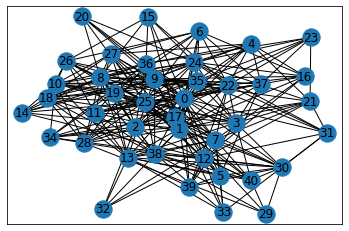

In [38]:
n_edges=450
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 3. 3.]
 [1. 0. 0. ... 6. 6. 6.]
 [1. 0. 0. ... 6. 0. 6.]
 ...
 [3. 6. 6. ... 0. 1. 0.]
 [3. 6. 0. ... 1. 0. 0.]
 [3. 6. 6. ... 0. 0. 0.]]
(33, 7, 17.073170731707318)
3.2439024390243905
2.7142857142857144
14.285714285714286
0.7027258678609274
0.18002322880371663
It's done!!!


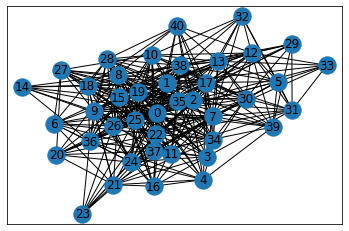

In [40]:
n_edges=550
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

LCC: 41
generated_graph:  (41, 41)
scores_matrix:  (41, 41)
graph: 
graph nodes: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
_________
 [[0. 1. 1. ... 3. 3. 3.]
 [1. 0. 0. ... 6. 6. 6.]
 [1. 0. 0. ... 6. 0. 6.]
 ...
 [3. 6. 6. ... 0. 1. 1.]
 [3. 6. 0. ... 1. 0. 0.]
 [3. 6. 6. ... 1. 0. 0.]]
(35, 8, 19.51219512195122)
3.268292682926829
2.7346938775510203
16.3265306122449
0.725521433706183
0.18350754936120792
It's done!!!


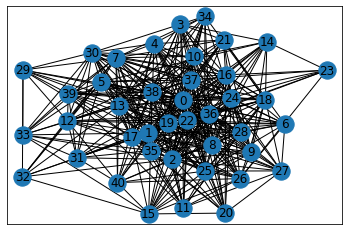

In [42]:
n_edges=800
generated_graph=utils.graph_from_scores(scores_matrix,n_edges)
lcc_= utils.statistics_LCC(generated_graph)
print("LCC:", len(lcc_))
print("generated_graph: ", generated_graph.shape)
#print(generated_graph)
print("scores_matrix: ", scores_matrix.shape)
#print(scores_matrix)
graph_utils.plot_graph(generated_graph)
utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)

In [ ]:
# utils.create_model_based_on_graph(out1,out2,out3,out4,out5,out6,out7,generated_graph)
# graph_utils.graph_similarity(_A_obs,generated_graph,0, 0,180)

#### Evaluate generalization via link prediction

In [ ]:
test_labels = np.concatenate((np.ones(len(test_ones)), np.zeros(len(test_zeros))))
test_scores = np.concatenate((scores_matrix[tuple(test_ones.T)].A1, scores_matrix[tuple(test_zeros.T)].A1))
print("test_scores : ",test_scores)

In [ ]:
roc_auc_score(test_labels, test_scores)

In [ ]:
average_precision_score(test_labels, test_scores)